<a href="https://colab.research.google.com/github/maronem/FER_App/blob/main/FER_MODEL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import torch
from torch import nn

# We need PyTorch 1.10.0
torch.__version__

'2.0.0+cu118'

In [4]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Setup File Paths and upload data


In [5]:
import requests 
import zipfile 
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "FER_images"

# If folder doesn't exist, download and prepare it
if image_path.is_dir():
  print(f"{image_path} already exists... skipping download")
else:
  print(f"Creating image path: {image_path}")
  image_path.mkdir(parents=True,
                   exist_ok=True)

Creating image path: data/FER_images


In [6]:
image_path

PosixPath('data/FER_images')

In [7]:
# Download pizza_steak_sushi data
with open(data_path/"FER_APP.zip", "wb") as f:
  request = requests.get("https://github.com/maronem/FER_App/raw/main/data/FER_APP.zip")
  print("Downloading FER_APP.zip...")
  f.write(request.content)

# Unzip data file
with zipfile.ZipFile(data_path / "FER_APP.zip", "r") as zip_ref:
  print("Unzipping data file...")
  zip_ref.extractall(image_path)

Unzipping data file...


In [8]:
image_path = image_path / "FER_APP"
image_path

PosixPath('data/FER_images/FER_APP')

## Explore data

In [9]:
import os

def dir_walkthrough(dir_path):
  """ Walks through dir_path and returns it's contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirpath)} directories and {len(filenames)} images in '{dirpath}'")

In [10]:
dir_walkthrough(image_path)

There are 23 directories and 0 images in 'data/FER_images/FER_APP'
There are 29 directories and 0 images in 'data/FER_images/FER_APP/train'
There are 37 directories and 4965 images in 'data/FER_images/FER_APP/train/neutral'
There are 37 directories and 436 images in 'data/FER_images/FER_APP/train/disgust'
There are 34 directories and 4097 images in 'data/FER_images/FER_APP/train/fear'
There are 35 directories and 7215 images in 'data/FER_images/FER_APP/train/happy'
There are 35 directories and 3995 images in 'data/FER_images/FER_APP/train/angry'
There are 38 directories and 3171 images in 'data/FER_images/FER_APP/train/surprise'
There are 33 directories and 4830 images in 'data/FER_images/FER_APP/train/sad'
There are 28 directories and 0 images in 'data/FER_images/FER_APP/test'
There are 36 directories and 1233 images in 'data/FER_images/FER_APP/test/neutral'
There are 36 directories and 111 images in 'data/FER_images/FER_APP/test/disgust'
There are 33 directories and 1024 images in 'd

In [11]:
# Setup train and test directories

train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/FER_images/FER_APP/train'),
 PosixPath('data/FER_images/FER_APP/test'))

## Visualize data images

In [12]:
image_path

PosixPath('data/FER_images/FER_APP')

Random img path: data/FER_images/FER_APP/train/fear/Training_31603340.jpg
Img class: fear
Img height: 48
Img width: 48


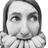

In [13]:
import random
from PIL import Image

#random.seed(42)

# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))
#image_path_list[:10]

# Select random image
rand_img_path = random.choice(image_path_list)
#print(rand_img_path)

# Get image class 
rand_img_class = rand_img_path.parent.stem
#print(img_class)

# Open img using PIL
rand_img = Image.open(rand_img_path)

print(f"Random img path: {rand_img_path}")
print(f"Img class: {rand_img_class}")
print(f"Img height: {rand_img.height}")
print(f"Img width: {rand_img.width}")
rand_img

## Setup Data Transforms

`torchvision.transforms` documentation - https://pytorch.org/vision/stable/transforms.html

In [14]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Compose img transform
img_transform = transforms.Compose([
    # Randomly flip imgs on horizontal plane
    transforms.RandomHorizontalFlip(p=0.5),
    # Augment color aspects of img
    transforms.ColorJitter(brightness=(0.5,1.5),
                           contrast=(1),
                           saturation=(0.5,1.5),
                           hue=(-0.1,0.1)),
    # Turn img into torch Tensor
    transforms.ToTensor()
])




In [15]:
img_transform(rand_img).dtype, img_transform(rand_img).shape

(torch.float32, torch.Size([1, 48, 48]))

In [16]:
import matplotlib.pyplot as plt

def plot_img_transform(image_paths, transform, n=3, seed=None):
  """
  Selects random images from a path and transforms/plots original vs. transformed.
  """
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f, cmap = plt.cm.gray)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

    # Transformed image
    transformed_img = transform(f).permute(1,2,0) # matplotlib uses (H,W,C)
    ax[1].imshow(transformed_img, cmap = plt.cm.gray)
    ax[1].set_title(f"Transformed\nSize: {transformed_img.shape}")
    ax[1].axis(False)

    fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=12)


  

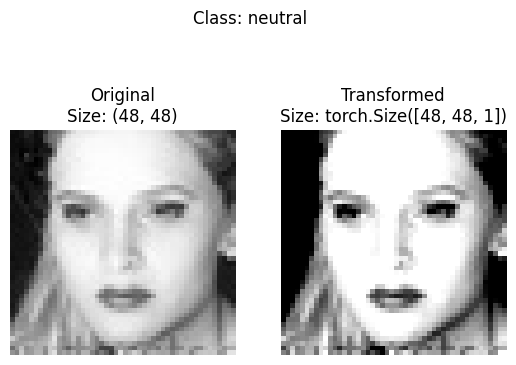

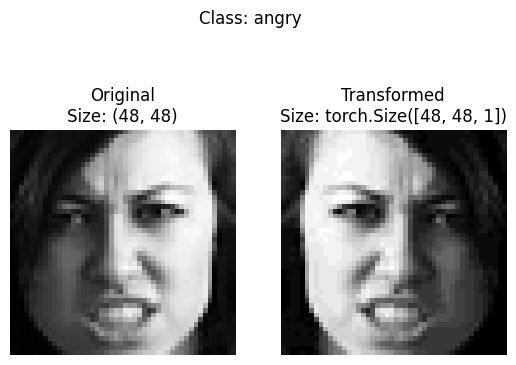

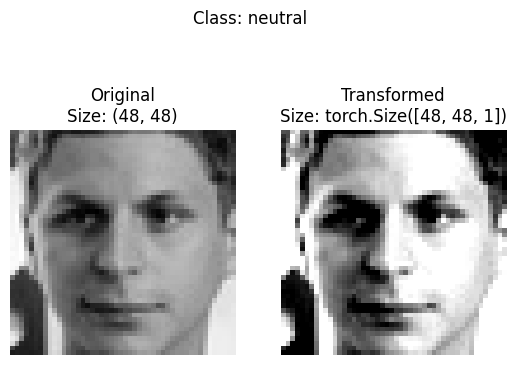

In [17]:
plot_img_transform(image_paths=image_path_list,
                   transform=img_transform,
                   n=3,
                   seed=None)

## Load image data using ImageFolder

`torchvision.datasets.ImageFolder()` - https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html?highlight=imagefolder

In [18]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Compose train and test transforms
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1), # to avoid dataloader overriding 1 color channel?
    # Randomly flip imgs on horizontal plane
    transforms.RandomHorizontalFlip(p=0.5),
    # Augment color aspects of img
    transforms.ColorJitter(brightness=(0.5,1.5),
                           contrast=(1),
                           saturation=(0.5,1.5),
                           hue=(-0.1,0.1)),
    # Turn img into torch Tensor
    transforms.Grayscale(num_output_channels=1), # to avoid dataloader overriding 1 color channel?
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

In [19]:
# Create datasets using ImageFolder
from torchvision import datasets

train_data = datasets.ImageFolder(root=train_dir,
                                  transform=train_transform,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=test_transform,
                                 target_transform=None)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 28709
     Root location: data/FER_images/FER_APP/train
     StandardTransform
 Transform: Compose(
                Grayscale(num_output_channels=1)
                RandomHorizontalFlip(p=0.5)
                ColorJitter(brightness=(0.5, 1.5), contrast=(0.0, 2.0), saturation=(0.5, 1.5), hue=(-0.1, 0.1))
                Grayscale(num_output_channels=1)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 7178
     Root location: data/FER_images/FER_APP/test
     StandardTransform
 Transform: Compose(
                Grayscale(num_output_channels=1)
                ToTensor()
            ))

In [20]:
# Get class names as list and dict
class_list = train_data.classes
class_dict = train_data.class_to_idx

class_list, class_dict

(['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'],
 {'angry': 0,
  'disgust': 1,
  'fear': 2,
  'happy': 3,
  'neutral': 4,
  'sad': 5,
  'surprise': 6})

In [21]:
len(train_data), len(test_data)

(28709, 7178)

## Turn images into DataLoaders

In [22]:
from torch.utils.data import DataLoader

# Create train dataloader
BATCH_SIZE = 120

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=1,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=1,
                             shuffle=False)

print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7f65ce346aa0>, <torch.utils.data.dataloader.DataLoader object at 0x7f65ce345b40>)
Length of train dataloader: 240 batches of 120
Length of test dataloader: 60 batches of 120


In [23]:
# Check what is in the dataloader(s)

train_features_batch, train_labels_batch = next(iter(train_dataloader))
test_features_batch, test_labels_batch = next(iter(test_dataloader))

print(f"TRAIN DATALOADER")
print(f"Train Features Shape: {train_features_batch.shape}")
print(f"Train Labels Shape: {train_labels_batch.shape}")
print("\n")
print(f"TEST DATALOADER")
print(f"Test Features Shape: {test_features_batch.shape}")
print(f"Test Labels Shape: {test_labels_batch.shape}")

TRAIN DATALOADER
Train Features Shape: torch.Size([120, 1, 48, 48])
Train Labels Shape: torch.Size([120])


TEST DATALOADER
Test Features Shape: torch.Size([120, 1, 48, 48])
Test Labels Shape: torch.Size([120])


## Why are our images showing 3 color channels?

!!! To combat this I used a grayscale transform and it is fixed :)

In [24]:
rand_img.getbands(), rand_img.mode

(('L',), 'L')

In [25]:
import numpy as np

rand_img_array = np.array(rand_img)
rand_img_array

array([[254, 255, 254, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 253, ..., 255, 255, 255],
       ...,
       [145, 151, 103, ..., 211, 253, 252],
       [229, 130,  61, ..., 251, 255, 255],
       [211,  85,  94, ..., 254, 255, 255]], dtype=uint8)

In [26]:
rand_img_array.shape # notice the shape has dropped the color channel

(48, 48)

## Model 0: Without data augmentation

### Create model_0 transforms and load data

In [27]:
# Create simple transfrom

simple_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

In [28]:
# Load and transform data
from torchvision import datasets

train_data_simple = datasets.ImageFolder(root=train_dir,
                                         transform=simple_transform)

test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=simple_transform)

train_data_simple, test_data_simple

(Dataset ImageFolder
     Number of datapoints: 28709
     Root location: data/FER_images/FER_APP/train
     StandardTransform
 Transform: Compose(
                Grayscale(num_output_channels=1)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 7178
     Root location: data/FER_images/FER_APP/test
     StandardTransform
 Transform: Compose(
                Grayscale(num_output_channels=1)
                ToTensor()
            ))

In [29]:
# Turn datasets into dataloaders
import os
from torch.utils.data import dataloader

# Set up batch size/num workers
BATCH_SIZE = 120
NUM_WORKERS = os.cpu_count()

# Create dataloaders
train_dataloader_simple = DataLoader(dataset=train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=True)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    num_workers=NUM_WORKERS,
                                    shuffle=False)

In [30]:
train_feat_simple_batch, train_label_simple_batch = next(iter(train_dataloader_simple))
test_feat_simple_batch, test_label_simple_batch = next(iter(test_dataloader_simple))

train_feat_simple_batch.shape, test_feat_simple_batch.shape

(torch.Size([120, 1, 48, 48]), torch.Size([120, 1, 48, 48]))

### model_0 CNN

Using CNN arcitecture from https://arxiv.org/ftp/arxiv/papers/2206/2206.09509.pdf as a reference

In [31]:
# Create model_0 CNN

class FERModelV0(nn.Module):
  """
  Model arcitecture references from paper:
  https://arxiv.org/ftp/arxiv/papers/2206/2206.09509.pdf
  """

  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()

    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )

    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )

    self.conv_block_3 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*6*6,
                  out_features=output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    print(f"conv_block_1: {x.shape}")
    x = self.conv_block_2(x)
    print(f"conv_block_2: {x.shape}")
    x = self.conv_block_3(x)
    print(f"conv_block_3: {x.shape}")
    x = self.classifier(x)
    print(f"classifier: {x.shape}")
    return x


In [32]:
# Instantiate model_0
torch.manual_seed(42)

model_0 = FERModelV0(input_shape=1, #num of color channels
                     hidden_units=64,
                     output_shape=len(class_list)).to(device)

model_0, len(class_list), device

(FERModelV0(
   (conv_block_1): Sequential(
     (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (3): ReLU()
     (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   )
   (conv_block_2): Sequential(
     (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (3): ReLU()
     (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (5): ReLU()
     (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   )
   (conv_block_3): Sequential(
     (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (3): ReLU()
     (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation

### Try a forward pass on single image batch to test model

In [33]:
# Get single image batch

image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

(torch.Size([120, 1, 48, 48]), torch.Size([120]))

In [34]:
# Try forward pass
model_0(image_batch.to(device))

conv_block_1: torch.Size([120, 64, 24, 24])
conv_block_2: torch.Size([120, 64, 12, 12])
conv_block_3: torch.Size([120, 64, 6, 6])
classifier: torch.Size([120, 7])


tensor([[-0.0035,  0.0028,  0.0119,  0.0081, -0.0158,  0.0038,  0.0111],
        [-0.0030,  0.0036,  0.0111,  0.0088, -0.0158,  0.0035,  0.0112],
        [-0.0033,  0.0028,  0.0118,  0.0082, -0.0157,  0.0042,  0.0112],
        [-0.0034,  0.0029,  0.0117,  0.0080, -0.0156,  0.0039,  0.0113],
        [-0.0030,  0.0038,  0.0107,  0.0090, -0.0160,  0.0035,  0.0111],
        [-0.0035,  0.0032,  0.0111,  0.0085, -0.0159,  0.0035,  0.0111],
        [-0.0033,  0.0033,  0.0113,  0.0089, -0.0159,  0.0038,  0.0111],
        [-0.0032,  0.0035,  0.0114,  0.0087, -0.0160,  0.0035,  0.0110],
        [-0.0033,  0.0025,  0.0121,  0.0077, -0.0154,  0.0041,  0.0114],
        [-0.0035,  0.0036,  0.0114,  0.0088, -0.0158,  0.0037,  0.0113],
        [-0.0032,  0.0034,  0.0112,  0.0083, -0.0160,  0.0037,  0.0109],
        [-0.0036,  0.0027,  0.0121,  0.0080, -0.0159,  0.0041,  0.0110],
        [-0.0032,  0.0025,  0.0123,  0.0078, -0.0153,  0.0037,  0.0112],
        [-0.0032,  0.0028,  0.0119,  0.0083, -0.015

In [35]:
64*6*6

2304

### Use torchinfo to view model summary

In [36]:
pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [37]:
from torchinfo import summary

BATCH_SIZE = 120 
summary(model=model_0,
        input_size=[BATCH_SIZE,1,48,48])

conv_block_1: torch.Size([120, 64, 24, 24])
conv_block_2: torch.Size([120, 64, 12, 12])
conv_block_3: torch.Size([120, 64, 6, 6])
classifier: torch.Size([120, 7])


Layer (type:depth-idx)                   Output Shape              Param #
FERModelV0                               [120, 7]                  --
├─Sequential: 1-1                        [120, 64, 24, 24]         --
│    └─Conv2d: 2-1                       [120, 64, 48, 48]         640
│    └─ReLU: 2-2                         [120, 64, 48, 48]         --
│    └─Conv2d: 2-3                       [120, 64, 48, 48]         36,928
│    └─ReLU: 2-4                         [120, 64, 48, 48]         --
│    └─MaxPool2d: 2-5                    [120, 64, 24, 24]         --
├─Sequential: 1-2                        [120, 64, 12, 12]         --
│    └─Conv2d: 2-6                       [120, 64, 24, 24]         36,928
│    └─ReLU: 2-7                         [120, 64, 24, 24]         --
│    └─Conv2d: 2-8                       [120, 64, 24, 24]         36,928
│    └─ReLU: 2-9                         [120, 64, 24, 24]         --
│    └─Conv2d: 2-10                      [120, 64, 24, 24]         36,92

### Loss, Optimizer, Train/Test loops

`train_step()` - takes in a model and dataloader and trains the model on the dataloader

`test_step()` - takes in a model and dataloader and evaluates the model on the dataloader

In [38]:
# Import torchmetrics, setup loss function & optimizer

try:
  import torchmetrics
except:
  !pip install torchmetrics
  import torchmetrics

from torchmetrics import Accuracy

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.001)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 10.5 MB/s eta 0:00:00


In [39]:
# Setup training loop function

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):

  # Put model in train mode
  model.train()

  # Set cumulative loss & acc == 0
  train_loss, train_acc = 0,0

  # Set model to target device
  model.to(device)

  # Loop though data loader batches
  for batch, (X,y) in enumerate(dataloader):
    X,y = X.to(device), y.to(device)

    # 1. Foward pass
    y_pred = model(X) # output model logits

    # 2. Calculate loss 
    loss = loss_fn(y_pred, y) # convert logits -> pred probs
    train_loss += loss.item()

    # 3. Set optimizer to zero grad
    optimizer.zero_grad()

    # 4. Backpropagation
    loss.backward()

    # 5. Step optimizer - gradient descent
    optimizer.step()

    # Calculate loss and acc per epoch
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class==y).sum().item()/len(y_pred)
  
  # Adjust metrics to get avg. loss and acc per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

In [40]:
# Create test step function

def test_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               device: torch.device = device):
  
  # Put model in eval mode
  model.eval()

  # Set cumulative test loss/acc to 0
  test_loss, test_acc = 0,0

  # Turn on inference mode
  with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (X,y) in enumerate(dataloader):

      # Send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      test_pred_logits = model(X)

      # 2. Calculate cumulative test loss
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      # Calculate accuracy
      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += (test_pred_labels==y).sum().item() / len(test_pred_labels)

    # Calculate test loss/acc per batch
    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)
    return test_loss, test_acc
    

In [41]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  # Note: you need the "raw" GitHub URL for this to work
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

### Create `train()` function

In [48]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          device = device):
  
  # Create empty results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}
  
  # Loop through training and testing steps
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model = model,
                                       dataloader = train_dataloader,
                                       loss_fn = loss_fn,
                                       optimizer = optimizer,
                                       accuracy_fn = torchmetrics.Accuracy(task = 'multiclass', num_classes=len(class_list)).to(device),
                                       device = device)
    test_loss, test_acc = test_step(model = model,
                                    dataloader = test_dataloader,
                                    loss_fn = loss_fn,
                                    device = device)
    
    # Print out results
    print(f"Epoch: {epoch} | Train Loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

    # Update results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  return results

### Train and evaluate model_0

In [43]:
model_0, model_0.parameters

(FERModelV0(
   (conv_block_1): Sequential(
     (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (3): ReLU()
     (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   )
   (conv_block_2): Sequential(
     (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (3): ReLU()
     (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (5): ReLU()
     (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   )
   (conv_block_3): Sequential(
     (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (3): ReLU()
     (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation

In [54]:
# Set epochs
NUM_EPOCHS = 20

# Reinstantiate model_0
model_0 = FERModelV0(input_shape=1, #num of color channels
                     hidden_units=64,
                     output_shape=len(train_data.classes)).to(device)

# Setup loss fn / optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_0.parameters(),
                            lr = 0.001)

# Setup train timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader = train_dataloader_simple,
                        test_dataloader = test_dataloader_simple,
                        optimizer = optimizer,
                        loss_fn = loss_fn,
                        epochs=NUM_EPOCHS)

# End timer and print train time
end_time = timer()
print(f"Total train time model_0: {end_time-start_time:.3f} seconds")

  0%|          | 0/20 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
conv_block_3: torch.Size([120, 64, 6, 6])
classifier: torch.Size([120, 7])
conv_block_1: torch.Size([120, 64, 24, 24])
conv_block_2: torch.Size([120, 64, 12, 12])
conv_block_3: torch.Size([120, 64, 6, 6])
classifier: torch.Size([120, 7])
conv_block_1: torch.Size([120, 64, 24, 24])
conv_block_2: torch.Size([120, 64, 12, 12])
conv_block_3: torch.Size([120, 64, 6, 6])
classifier: torch.Size([120, 7])
conv_block_1: torch.Size([120, 64, 24, 24])
conv_block_2: torch.Size([120, 64, 12, 12])
conv_block_3: torch.Size([120, 64, 6, 6])
classifier: torch.Size([120, 7])
conv_block_1: torch.Size([120, 64, 24, 24])
conv_block_2: torch.Size([120, 64, 12, 12])
conv_block_3: torch.Size([120, 64, 6, 6])
classifier: torch.Size([120, 7])
conv_block_1: torch.Size([120, 64, 24, 24])
conv_block_2: torch.Size([120, 64, 12, 12])
conv_block_3: torch.Size([120, 64, 6, 6])
classifier: torch.Size([120, 7])
conv_block_1: torch.Size([120, 64, 24, 24])
conv_block_2: t

In [60]:
model_0_results

{'train_loss': [1.8089833443363508,
  1.6158525665601096,
  1.4230375746885935,
  1.3068652073542277,
  1.2181144133210182,
  1.144729452331861,
  1.0759482542673746,
  1.0160883399347465,
  0.963287475456794,
  0.8924896727005641,
  0.836129364122947,
  0.7671868778765202,
  0.7013226741304001,
  0.6351382656643788,
  0.5741361923515796,
  0.5163599909593661,
  0.46061584216852985,
  0.4102653294801712,
  0.35203493653486173,
  0.32359357103705405],
 'train_acc': [0.24864463601532555,
  0.3662679597701151,
  0.4558261494252872,
  0.503881704980843,
  0.5382614942528735,
  0.5693223180076626,
  0.5992684386973182,
  0.6221599616858239,
  0.6409243295019156,
  0.6707207854406128,
  0.6951005747126434,
  0.7186470306513411,
  0.7467073754789267,
  0.7691774425287357,
  0.7911817528735641,
  0.8117277298850574,
  0.8334530651340994,
  0.8521982758620676,
  0.8734135536398464,
  0.8819348659003833],
 'test_loss': [1.7716248095035554,
  1.5063591460386911,
  1.3696733504533767,
  1.29864955

In [61]:
import matplotlib.pyplot as plt

# Create function to plot results dictionary
def loss_plot(results: dict[str, list[float]]):
  """Plots training curves of a results dictionary"""
  # Get loss values
  loss = results["train_loss"]
  test_loss = results["test_loss"]

  # Get accuracy values
  acc = results["train_acc"]
  test_acc = results["test_acc"]

  # Count epochs
  epochs = range(len(results["train_loss"]))

  # Setup plots
  # Loss plot
  plt.figure(figsize=(15,7))
  plt.subplot(1,2,1)
  plt.plot(epochs, loss, label="Train Loss")
  plt.plot(epochs, test_loss, label="Test Loss")
  plt.title("Loss")
  plt.xlabel("Epoch")
  plt.legend()
  # Acc plot
  plt.subplot(1,2,2)
  plt.plot(epochs, acc, label="Train Accuracy")
  plt.plot(epochs, test_acc, label="Test Accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epoch")
  plt.legend();

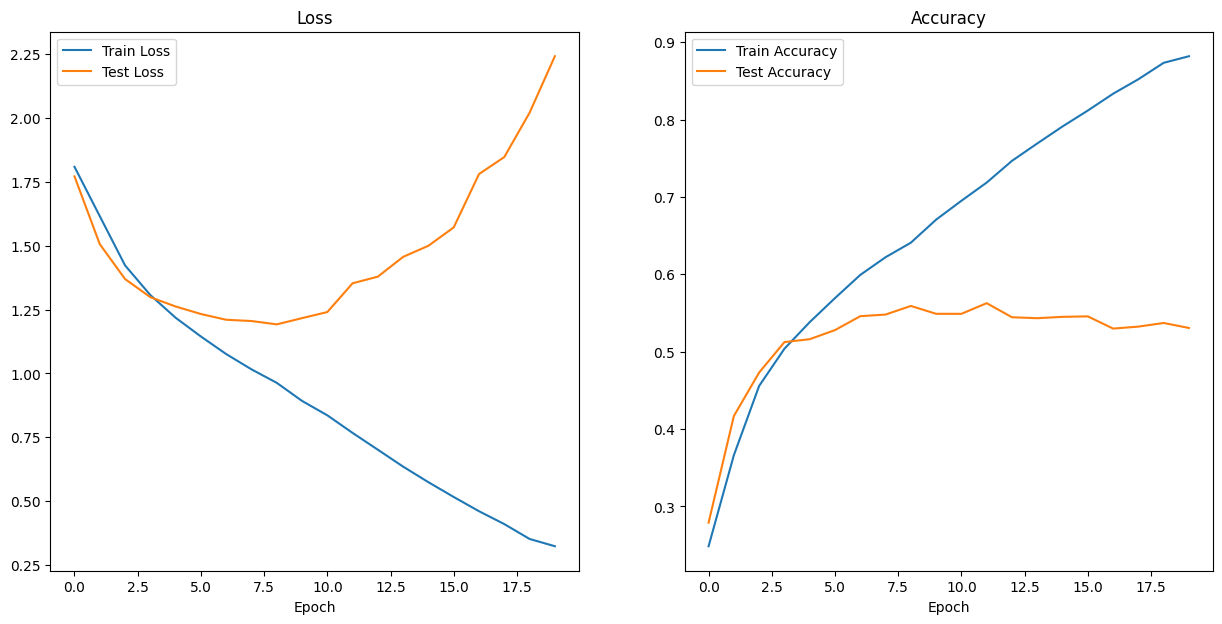

In [62]:
loss_plot(model_0_results)

#### Model has ~0.4 higher training accuracy value compared to test accuracy, model seems to be overfitting, will add a dropout hyperparameter (=0.5) in model_1.

## Model 1: Dropout=0.5 -> 0.2, no data augmentation

In [65]:
# Create model_1 CNN

class FERModelV1(nn.Module):
  """
  Model arcitecture references from paper:
  https://arxiv.org/ftp/arxiv/papers/2206/2206.09509.pdf

  This model incorporates dropout =0.5->0.2 before each ReLU() layer to combat overfitting seen in model_0
  """

  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()

    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.Dropout(0.5),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.Dropout(0.2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )

    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.Dropout(0.5),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.Dropout(0.2),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )

    self.conv_block_3 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.Dropout(0.5),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.Dropout(0.2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*6*6,
                  out_features=output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    print(f"conv_block_1: {x.shape}")
    x = self.conv_block_2(x)
    print(f"conv_block_2: {x.shape}")
    x = self.conv_block_3(x)
    print(f"conv_block_3: {x.shape}")
    x = self.classifier(x)
    print(f"classifier: {x.shape}")
    return x


In [67]:
# Instantiate model_1
torch.manual_seed(42)

model_1 = FERModelV1(input_shape=1, #num of color channels
                     hidden_units=64,
                     output_shape=len(class_list)).to(device)

model_1, len(class_list), device

(FERModelV1(
   (conv_block_1): Sequential(
     (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): Dropout(p=0.5, inplace=False)
     (2): ReLU()
     (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (4): Dropout(p=0.2, inplace=False)
     (5): ReLU()
     (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   )
   (conv_block_2): Sequential(
     (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): Dropout(p=0.5, inplace=False)
     (2): ReLU()
     (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (4): Dropout(p=0.2, inplace=False)
     (5): ReLU()
     (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (7): ReLU()
     (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   )
   (conv_block_3): Sequential(
     (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): Drop

In [68]:
# Try forward pass on image batch
model_1(image_batch.to(device))

conv_block_1: torch.Size([120, 64, 24, 24])
conv_block_2: torch.Size([120, 64, 12, 12])
conv_block_3: torch.Size([120, 64, 6, 6])
classifier: torch.Size([120, 7])


tensor([[ 6.4703e-03, -1.0781e-02,  5.2203e-03, -1.1084e-03, -2.3286e-02,
         -9.4141e-03, -2.6429e-04],
        [ 1.3254e-02, -8.8020e-03,  9.0458e-03,  3.1215e-03, -1.0704e-02,
         -3.3551e-03,  2.7394e-03],
        [ 4.7587e-03,  3.4976e-03,  5.2439e-03,  1.2977e-02, -1.8413e-02,
         -1.2240e-02,  4.3606e-03],
        [ 5.1405e-03, -1.7361e-02,  1.5175e-02,  9.5911e-03, -2.0149e-02,
         -3.1274e-05, -2.7592e-03],
        [ 3.5144e-03, -7.9874e-03,  1.1697e-02,  4.3345e-03, -1.4268e-02,
         -4.7985e-03,  7.6876e-03],
        [-1.8517e-03, -1.2771e-02, -3.4035e-03,  1.8537e-03, -1.7548e-02,
          7.1566e-03,  1.1566e-02],
        [ 1.6933e-03,  7.4134e-03, -5.6285e-03,  2.1382e-03, -1.9870e-02,
         -6.2159e-03,  6.3469e-03],
        [ 4.1175e-03, -3.9075e-03,  9.6288e-03,  8.1879e-03, -2.1197e-02,
         -2.8967e-04,  9.2828e-03],
        [ 9.6725e-03, -7.3167e-03,  7.1094e-03,  1.3030e-02,  1.4657e-03,
         -1.0616e-02, -7.8653e-03],
        [-

In [69]:
# Model 1 summary
from torchinfo import summary

BATCH_SIZE = 120 
summary(model=model_1,
        input_size=[BATCH_SIZE,1,48,48])

conv_block_1: torch.Size([120, 64, 24, 24])
conv_block_2: torch.Size([120, 64, 12, 12])
conv_block_3: torch.Size([120, 64, 6, 6])
classifier: torch.Size([120, 7])


Layer (type:depth-idx)                   Output Shape              Param #
FERModelV1                               [120, 7]                  --
├─Sequential: 1-1                        [120, 64, 24, 24]         --
│    └─Conv2d: 2-1                       [120, 64, 48, 48]         640
│    └─Dropout: 2-2                      [120, 64, 48, 48]         --
│    └─ReLU: 2-3                         [120, 64, 48, 48]         --
│    └─Conv2d: 2-4                       [120, 64, 48, 48]         36,928
│    └─Dropout: 2-5                      [120, 64, 48, 48]         --
│    └─ReLU: 2-6                         [120, 64, 48, 48]         --
│    └─MaxPool2d: 2-7                    [120, 64, 24, 24]         --
├─Sequential: 1-2                        [120, 64, 12, 12]         --
│    └─Conv2d: 2-8                       [120, 64, 24, 24]         36,928
│    └─Dropout: 2-9                      [120, 64, 24, 24]         --
│    └─ReLU: 2-10                        [120, 64, 24, 24]         --
│    └

### Train and eval model_1

In [88]:
# Train and evaluate model_1

NUM_EPOCHS = 20

# Setup loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_1.parameters(),
                             lr=0.001)

# Start timer
from timeit import default_timer as timer
start_time = timer()

# Train model_1
model_1_results = train(model=model_1,
                        train_dataloader = train_dataloader_simple,
                        test_dataloader = test_dataloader_simple,
                        optimizer = optimizer,
                        loss_fn = loss_fn,
                        epochs = NUM_EPOCHS)

# End timer / print
end_time = timer()
print(f"Total train time model_1: {end_time-start_time:.3f} seconds")

  0%|          | 0/20 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
conv_block_3: torch.Size([120, 64, 6, 6])
classifier: torch.Size([120, 7])
conv_block_1: torch.Size([120, 64, 24, 24])
conv_block_2: torch.Size([120, 64, 12, 12])
conv_block_3: torch.Size([120, 64, 6, 6])
classifier: torch.Size([120, 7])
conv_block_1: torch.Size([120, 64, 24, 24])
conv_block_2: torch.Size([120, 64, 12, 12])
conv_block_3: torch.Size([120, 64, 6, 6])
classifier: torch.Size([120, 7])
conv_block_1: torch.Size([120, 64, 24, 24])
conv_block_2: torch.Size([120, 64, 12, 12])
conv_block_3: torch.Size([120, 64, 6, 6])
classifier: torch.Size([120, 7])
conv_block_1: torch.Size([120, 64, 24, 24])
conv_block_2: torch.Size([120, 64, 12, 12])
conv_block_3: torch.Size([120, 64, 6, 6])
classifier: torch.Size([120, 7])
conv_block_1: torch.Size([120, 64, 24, 24])
conv_block_2: torch.Size([120, 64, 12, 12])
conv_block_3: torch.Size([120, 64, 6, 6])
classifier: torch.Size([120, 7])
conv_block_1: torch.Size([120, 64, 24, 24])
conv_block_2: t

In [89]:
model_1_results

{'train_loss': [1.1637132758895556,
  1.1443912943204244,
  1.131102338184913,
  1.1196008170644443,
  1.1065560735762119,
  1.1013232946395874,
  1.0903078983227412,
  1.0771376696725687,
  1.0730954453349113,
  1.0686357614894708,
  1.059632292141517,
  1.055628231416146,
  1.0454960331320762,
  1.0443811198075612,
  1.0379288867115974,
  1.0297911976774534,
  1.0229525166253248,
  1.022304115196069,
  1.0115402728319167,
  1.013053895284732],
 'train_acc': [0.5618666187739461,
  0.5659243295019155,
  0.5705423850574711,
  0.5750622605363986,
  0.5792385057471265,
  0.5850179597701148,
  0.5859542624521069,
  0.5917229406130268,
  0.5949868295019157,
  0.5949221743295016,
  0.6017181513409964,
  0.5997533524904217,
  0.6046683429118773,
  0.6050323275862066,
  0.6103148946360152,
  0.6137021072796933,
  0.6118426724137932,
  0.6165648946360155,
  0.6174269636015324,
  0.618449473180077],
 'test_loss': [1.150041722257932,
  1.1490825628240904,
  1.1387071798245112,
  1.121839575966199

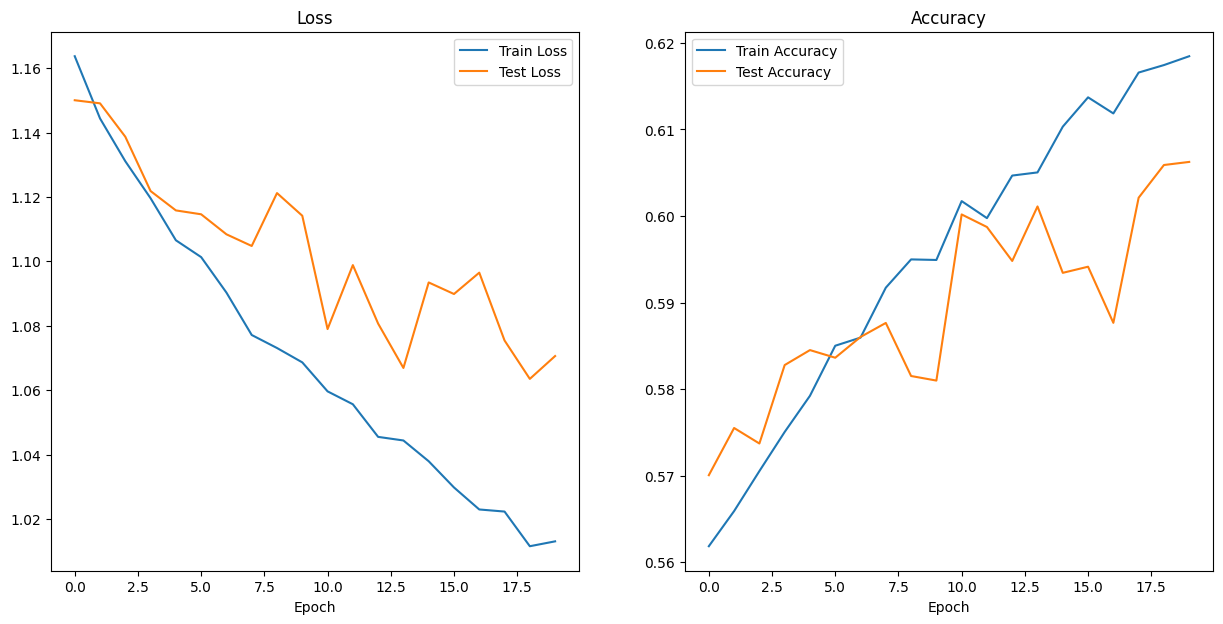

In [90]:
loss_plot(model_1_results)

#### Dropout seemed to improve model overfitting and improved accuracy up to ~60% !

In [91]:
import pandas as pd

model_0_sum = pd.DataFrame.from_dict(model_0_results)
model_0_sum

,train_loss,train_acc,test_loss,test_acc
0,1.808983,0.248645,1.771625,0.279093
1,1.615853,0.366268,1.506359,0.416916
2,1.423038,0.455826,1.369673,0.473169
3,1.306865,0.503882,1.298650,0.512474
4,1.218114,0.538261,1.262151,0.516222
5,1.144729,0.569322,1.232748,0.527968
6,1.075948,0.599268,1.210200,0.545933
7,1.016088,0.622160,1.205257,0.548064
8,0.963287,0.640924,1.192145,0.559172
9,0.892490,0.670721,1.216616,0.549033


In [92]:
model_1_sum = pd.DataFrame.from_dict(model_1_results)
model_1_sum

,train_loss,train_acc,test_loss,test_acc
0,1.163713,0.561867,1.150042,0.570068
1,1.144391,0.565924,1.149083,0.575519
2,1.131102,0.570542,1.138707,0.573727
3,1.119601,0.575062,1.121840,0.582786
4,1.106556,0.579239,1.115830,0.584515
5,1.101323,0.585018,1.114623,0.583634
6,1.090308,0.585954,1.108409,0.586029
7,1.077138,0.591723,1.104783,0.587650
8,1.073095,0.594987,1.121213,0.581522
9,1.068636,0.594922,1.114174,0.580995
